# t3pa2cls
script for convert .t3pa files to .t3pa_cls  
  
.t3pa file example:  
>Index $\quad$ Matrix $\quad$ Index	$\quad$ ToA	$\quad$ ToT $\quad$	FToA $\quad$ Overflow  
0  $\quad$ 4574 $\quad$ 832 $\quad$ 29 $\quad$ 6 $\quad$ 0  
1 $\quad$ 4831 $\quad$ 832 $\quad$ 35 $\quad$ 7 $\quad$ 0  
2 $\quad$ 4575 $\quad$ 832 $\quad$ 100 $\quad$ 8 $\quad$ 0  
3 $\quad$ 31031 $\quad$ 1745 $\quad$ 22 $\quad$ 11 $\quad$ 0  
.  
.  
.  
  
.t3pa_cls file example:
>% Index $\quad$ Matrix Index $\quad$ [ RowNo, ClmNo ] $\quad$ ToA $\quad$ FToA $\quad$ ( ToA_in_ns ) $\quad$ ToT ( ToT_in_keV ) $\quad$ Overflow  
>  
>\# 1, $\quad$ Nunmasked = 3, $\quad$ Nmasked = 0, $\quad$ Ntot = 3
\# Tfirst = 2.0787500000000000e+04 ns, $\quad$ Tlast = 2.0790625000000000e+04 ns, $\quad$ dT = 3.125000 ns, $\quad$ Etot = 64.428148 keV  
2 $\quad$ 4575 $\quad$ [ 17, 223 ] $\quad$ 832 $\quad$ 8 $\quad$ ( 2.0787500000000000e+04 ns ) $\quad$ 100 $\quad$ ( 37.867914 keV ) $\quad$ 0  
1 $\quad$ 4831 $\quad$ [ 18, 223 ] $\quad$ 832 $\quad$ 7 $\quad$ ( 2.0789062500000000e+04 ns ) $\quad$ 35 $\quad$ ( 14.733453 keV ) $\quad$ 0  
0 $\quad$ 4574 $\quad$ [ 17, 222 ] $\quad$ 832 $\quad$ 6 $\quad$ ( 2.0790625000000000e+04 ns ) $\quad$ 29 $\quad$ ( 11.826781 keV ) $\quad$ 0  
>  
>\# 2, $\quad$ Nunmasked = 3, $\quad$ Nmasked = 0, $\quad$ Ntot = 3
\# Tfirst = 4.3601562500000000e+04 ns, $\quad$ Tlast = 4.3607812500000000e+04 ns, $\quad$ dT = 6.250000 ns, $\quad$ Etot = 63.577435 keV  
5 $\quad$ 30775	$\quad$ [ 120, 55 ]	$\quad$ 1745 $\quad$ 15 $\quad$ ( 4.3601562500000000e+04 ns ) $\quad$ 99 $\quad$ ( 37.617059 keV ) $\quad$ 0  
4 $\quad$ 30776 $\quad$ [ 120, 56 ] $\quad$ 1745 $\quad$ 13 $\quad$ ( 4.3604687500000000e+04 ns ) $\quad$ 44 $\quad$ ( 14.715446 keV ) $\quad$ 0  
3 $\quad$ 31031 $\quad$ [ 121, 55 ] $\quad$ 1745 $\quad$ 11 $\quad$ ( 4.3607812500000000e+04 ns ) $\quad$2 2 $\quad$ ( 11.244929 keV ) $\quad$ 0  
>  
.  
.  
.  


In [1]:
import numpy as np
import math
#import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.cm as cm
#from matplotlib.mlab import griddata

from urllib.error import HTTPError # recognise the error stemming from missing data
#import urllib
import urllib.request

t3pa2cls_XII  - upravena fce energy(a, b, c, t, ToT, pocet_udalosti, RowNo, ClmNo) - nyni je se pocita i s pripadem "nan"
t3pa2cls_XV_pc - zkousim vyzobat vysoke energie (jednotlive interakce) - funkce single_interaction. Dale delam prumernou velikost stopy stopy interakce pro danou energii - funkce size_of_interactions_average. Dale delam spektra 2 casti vyboje podle zadaneho casu - primarne pro double breakdown, tj. funkce energy_spectra_doublebreakdown

In [2]:
#Define an exception which will be raised if the data is missing and stop the notebook execution
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
    
#shot_no = 44395  #test discharge for which the notebook will definitely work
shot_no = 0
shot = shot_no
identifier='H03-W0051_shot_'+str(shot)+'_450V'
detector = 'H03-W0051'

ds = np.DataSource('/tmp')  # temporary storage for downloaded files
scalars_URL = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/Results/{name}'

## Functions

In [3]:
def get_scalar(shot_no, name):
    return float(ds.open(scalars_URL.format(shot_no=shot_no, name=name)).read())
t_plasma_start = get_scalar(shot_no, 't_plasma_start')
t_plasma_end = get_scalar(shot_no, 't_plasma_end')
is_plasma = get_scalar(shot_no, 'b_plasma')

In [4]:
def get_file(shot, identifier):
    #Pick the discharge to analyse 
    URL = 'http://golem.fjfi.cvut.cz/shots/{shot}/Diagnostics/TimepixDetector/H03/{identifier}.t3pa'
    
    url = URL.format(shot=shot, identifier=identifier)
    try:
        file_name_t3pa=url
        with urllib.request.urlopen(file_name_t3pa) as ft3pa:
            line = ft3pa.readline()
            line = line.decode('utf‐8')
        ft3pa.close
    except HTTPError:
        print('File not found at %s. Aborting notebook execution.' % url)
        raise StopExecution
    
    return file_name_t3pa

In [5]:
def get_file_calib(name_calib):
    #Pick the discharge to analyse 
    URL = 'http://golem.fjfi.cvut.cz/shots/{shot}/Diagnostics/TimepixDetector/calib_matrix_H03/{name_calib}.txt'
    
    url = URL.format(shot=shot, name_calib=name_calib)
    #print(url)
    try:
        file_calib=url
        with urllib.request.urlopen(file_calib) as calib:
            line = calib.readline()
            line = line.decode('utf‐8')
        calib.close
    except HTTPError:
        print('File not found at %s. Aborting notebook execution.' % url)
        raise StopExecution
    
    return file_calib

In [6]:
def load_calib(file_calib):
    with urllib.request.urlopen(file_calib) as fc:
        calib=[] #vytvoreni 1D pole
        for i in range(0,256): #tj. rozsah 0-255
            temp = [] # docasne pole
            for j in range(0,256):
                temp.append(0) #naplneni docasneho pole 0
            calib.append(temp)  #naplneni pole a[] docasnym polem temp
            
        for i in range(0,256): #nacteni calib matice do pole calib
            line = fc.readline()
            line = line.decode('utf‐8')
            word=line.strip().split(' ')
            for j in range(0,256):
                #calib[i][j]=float(word[j]) #i = radek, j = sloupec0
                calib[j][i]=float(word[j]) #j = radek, i = sloupec0 - pouze pro stavajici kalibraci - verze XV
    fc.close       
    return calib

In [7]:
def load_t3pa_file(file_t3pa):
    index=[]
    matrix_index=[]
    ToA=[]
    ToT=[]
    FToA=[]
    overflow=[]
    pocet_udalosti = 0
    with urllib.request.urlopen(file_t3pa) as ft3pa:
        line = ft3pa.readline()
        line = line.decode('utf‐8')
        while True:
            line = ft3pa.readline()
            line = line.decode('utf‐8')
            word=line.strip().split('\t') #v t3pa souboru je oddelovac \t
            if line == '':
                break
            
            index.append(word[0])
            matrix_index.append(word[1])
            ToA.append(float(word[2]))
            ToT.append(float(word[3]))
            FToA.append(float(word[4]))
            overflow.append(float(word[5]))
            pocet_udalosti = pocet_udalosti + 1
    ft3pa.close
    return index,  matrix_index, ToA, ToT, FToA, overflow, pocet_udalosti

In [8]:
def noise(index,  matrix_index, ToA, ToT, FToA, overflow, pocet_udalosti): #tuto fci nemus9m explicitn2 volat - volam ji v fci load_t3pa
    pocet=int(0) #pocet sumicich pixelu
    konst=int(len(index)/1000)+1
    noise_matrix_index=[]
    for i in range(0,konst):      
        pom = [] # pomocne pole
        k=0 #pomocna promenna - udava, kolik je v czklu ve skutecnosti udalosti - aby nebyla chyba 'list index out of range'
        for j in range(0,1001):
            if i*1000+j>=len(index):
                break
            pom.append(matrix_index[i*1000+j])
            k=k+1
        for m in range(0,k):
                count=int(0) #pocet vvyskytu stejneho matrix index behem 1000 udalosti
                index_=int(-1) #budu testovat, jestli pixel na ktery koukam je sumici (abych ho nezapocital 2x)
                
                for p in range(0,pocet):
                    #index=int(p)
                    if pom[m]==noise_matrix_index[p]:
                        index_=p #pixel na ktery jsem uz koukal a byl sumici
                        break
                
                if index_ >=0 and pom[m]==noise_matrix_index[index_]:
                    continue
                                 
                for l in range(0,k):
                    if pom[m]==pom[l]:
                        count=count+1
                ####podminka na sumici pixely
                if count>=50: #kdyz se pixel vyskytne behem tisice udalosti vicekrat nez toto cislo, je sumici 
                    noise_matrix_index.append(pom[m])
                    #noise_matrix_index[pocet]=pom[i]
                    pocet=pocet+1
        pom.clear()           
        
    pocet_udalosti=len(index)
    
    for n in range (0,pocet_udalosti):
        for o in range(0,len(noise_matrix_index)):
            if n >=pocet_udalosti:
                    break
            if(matrix_index[n]==noise_matrix_index[o]):
                del matrix_index[n]
                del index[n]
                del ToA[n]
                del ToT[n]
                del FToA[n]
                del overflow[n]
                pocet_udalosti=pocet_udalosti-1
                continue
    return pocet_udalosti,index,  matrix_index, ToA, ToT, FToA, overflow

In [9]:
def t3pa_data(pocet_udalosti,index,  matrix_index, ToA, ToT, FToA, overflow):
    #rovnou vyhodim sumici pixely
    pocet_udalosti,index,  matrix_index, ToA, ToT, FToA, overflow=noise(index,  matrix_index, ToA, ToT, FToA, overflow, pocet_udalosti)
    RowNo=[]
    ClmNo=[]
    for i in range(0,len(matrix_index)):
        #RowNo.append(int(int(matrix_index[i]))//int(256))
        #ClmNo.append(int(int(matrix_index[i]))%int(256))
        ClmNo.append(int(int(matrix_index[i]))//int(256)) #ver XV - bude pro novou kalibraci - nyn9 to bere 3patnou kalibraci jednotlivych pixelu (cislovani radku a sloupcu stejne jako v pixetu)
        RowNo.append(int(int(matrix_index[i]))%int(256)) ##ver XV - bude super pro novou kalibraci - odpovida radkum a sloupcum v pixetu. Nyni bere spatne kalibrace pixelu (viz fce load_calib)
    return index,  matrix_index, ToA, ToT, FToA, overflow, pocet_udalosti, RowNo, ClmNo

In [10]:
def hit_map(detector,hit_map_fig,RowNo,ClmNo):
    plt.hist2d(RowNo,ClmNo,bins=(256,256),cmap='Blues')
    cb=plt.colorbar()
    cb.set_label('Counts in pixel')
    plt.xlabel('x [pixel]')
    plt.ylabel('y [pixel]')
    plt.title(detector)
    plt.savefig(hit_map_fig, dpi = 1000)
    return

In [11]:
def energy(a, b, c, t, ToT, pocet_udalosti, RowNo, ClmNo):
    E=[] #energy in keV
    #for i in range (0,pocet_udalosti):
    pom=0
    for i in range (0,len(ToT)):
        Sqrt=float(0.0)
        e1=float(0.0)
        e2=float(0.0)
        
        # promenna sqrt je vnitrek odmocniny
        Sqrt =  (((float(b[RowNo[i]][ClmNo[i]])+float(a[RowNo[i]][ClmNo[i]])*float(t[RowNo[i]][ClmNo[i]])-float(ToT[i])))*(((float(b[RowNo[i]][ClmNo[i]])+float(a[RowNo[i]][ClmNo[i]])*float(t[RowNo[i]][ClmNo[i]])-float(ToT[i])))) + (float(4)*float(a[RowNo[i]][ClmNo[i]])*float(c[RowNo[i]][ClmNo[i]]))) #zmena oproti verzi VI
        if float(Sqrt)<float(0):
            E.append(float(0))
            
            
        else:
            '''
            V kalibracni matici a se obcas vyskytne 0 -> ve vypoctu energie
            je tim padem deleni nulou -> energie diverguje. Jak to vyresit?
            zatim polozim energii = 0 (kdyz a=0), pak se uvidi
            
            nakonec udelam limitu vyrazu energie pro a->0 (L'hopital)
            '''
            if a[RowNo[i]][ClmNo[i]]==0:
                e1=((float(t[RowNo[i]][ClmNo[i]]))/float(2)) + ((((float(b[RowNo[i]][ClmNo[i]])+float(a[RowNo[i]][ClmNo[i]])*float(t[RowNo[i]][ClmNo[i]])-float(ToT[i]))*(float(t[RowNo[i]][ClmNo[i]]))) - 2*(float(c[RowNo[i]][ClmNo[i]])))/(float(2)*np.sqrt(float(Sqrt))))
                e2=((float(t[RowNo[i]][ClmNo[i]]))/float(2)) - ((((float(b[RowNo[i]][ClmNo[i]])+float(a[RowNo[i]][ClmNo[i]])*float(t[RowNo[i]][ClmNo[i]])-float(ToT[i]))*(float(t[RowNo[i]][ClmNo[i]]))) - 2*(float(c[RowNo[i]][ClmNo[i]])))/(float(2)*np.sqrt(float(Sqrt))))
                
            
            else:
                e1=((-(float(b[RowNo[i]][ClmNo[i]]) - (float(a[RowNo[i]][ClmNo[i]])*float(t[RowNo[i]][ClmNo[i]]))-float(ToT[i])))+np.sqrt(float(Sqrt)))/(float(2)*float(a[RowNo[i]][ClmNo[i]]))
                e2=((-(float(b[RowNo[i]][ClmNo[i]]) - (float(a[RowNo[i]][ClmNo[i]])*float(t[RowNo[i]][ClmNo[i]]))-float(ToT[i])))-np.sqrt(float(Sqrt)))/(float(2)*float(a[RowNo[i]][ClmNo[i]]))
                
            if a[RowNo[i]][ClmNo[i]]<0:
                e1=-1
                e2=-1
                
            if math.isnan(e1):
                e1=-1 
                
            if math.isnan(e2):
                e2=-1 
                
            if e1<0 and e2<0:
                E.append(float(0))
                
            if e1>=0 and e1>e2:
                E.append(float(e1))
                    
            if e2>=0 and e2>e1:
                E.append(float(e2))
                
            if e1>=0 and e2==e1:
                E.append(float(e1)) 
            
    return E

In [12]:
def Time(ToA, FToA, pocet_udalosti, RowNo, ClmNo):
    T=[] #time in ns
    for i in range (0,pocet_udalosti):
        Time=float(0.0)
        Time=(float(ToA[i])-((float(FToA[i])/float(16))))*float(25)
        T.append(float(Time))
    return T

In [13]:
def Timewalk_parameters_Si():
    #SI - korekce na TimeWalk - parametry
    A = -1.21988
    B = 4.33638
    C = 29.5075
    D = 1
    sigma_A=0.7013
    sigma_B=0.1366
    sigma_C=4.753
    sigma_D=0
    return A, B, C, D, sigma_A, sigma_B, sigma_C, sigma_D

In [14]:
def Timewalk(E,T):
    i=0
    A, B, C, D, sigma_A, sigma_B, sigma_C, sigma_D = Timewalk_parameters_Si()
    while i < len(T):
        timewalk=float(0)
        timewalk = (C / (E[i] - B)) + A 
        if(timewalk<0):
            timewalk=0
        T[i]=T[i]-timewalk
        i=i+1
        
    return E,T

In [15]:
def remove_interactions_with_zero_energy(index, matrix_index, ToA, ToT, FToA, overflow, RowNo, ClmNo, E, T):
    i=0
    treshold=5.015347
    while i < len(T):
        if E[i]<treshold: #E[i] < energy treshold
            index.pop(i)
            matrix_index.pop(i)
            ToA.pop(i)
            ToT.pop(i)
            FToA.pop(i)
            overflow.pop(i)
            RowNo.pop(i)
            ClmNo.pop(i)
            E.pop(i)
            T.pop(i)
            continue
        i=i+1
    return index, matrix_index, ToA, ToT, FToA, overflow, RowNo, ClmNo, E, T

In [16]:
def clustering_new(index, matrix_index, ToA, ToT, FToA, overflow, RowNo, ClmNo, E, T):
    dT=float(50)
    
    indexCl, TCl,ECl, matrix_indexCl, ToACl,ToTCl,FToACl,RowNoCl,ClmNoCl,overflowCl=[],[],[],[],[],[],[],[],[],[]
    StartLastElem=len(T)-1
    
    indexCl.append(int(index[StartLastElem]))
    TCl.append(float(T[StartLastElem]))
    ECl.append(float(E[StartLastElem]))
    matrix_indexCl.append(int(matrix_index[StartLastElem]))
    RowNoCl.append(int(RowNo[StartLastElem]))
    ClmNoCl.append(int(ClmNo[StartLastElem]))
    ToACl.append(float(ToA[StartLastElem]))
    ToTCl.append(float(ToT[StartLastElem]))
    FToACl.append(float(FToA[StartLastElem]))
    overflowCl.append(float(overflow[StartLastElem]))
    
    del index[StartLastElem]
    del T[StartLastElem]
    del E[StartLastElem]
    del matrix_index[StartLastElem]
    del RowNo[StartLastElem]
    del ClmNo[StartLastElem]
    del ToA[StartLastElem]
    del ToT[StartLastElem]
    del FToA[StartLastElem]
    del overflow[StartLastElem]
    
    j=1
    pom=float(TCl[0]+dT)
    while(j >0):
        if(len(T) == 0):
           break
        k=0
        j=0
        while (k<=(len(TCl)-1)):
            i=len(T)-1
            if(len(T) == 0):
                break
            pocet_sousedu=0 #pocet sousednich pixelu - mohou byt maximalne 4
            delka=0
            # verze X
            count=0 #pomocna promanna, kterou urcuji, ze se ma nasledujici cyklus while projit jeste jednou, pokud je i = -1
            while(float(T[i])<=(pom)):
                delka=delka+1
                if(((((int(RowNoCl[k]))==(int(RowNo[i])+1))or((int(RowNoCl[k]))==(int(RowNo[i])-1))) and ((int(ClmNoCl[k]))==(int(ClmNo[i])))) or (((int(RowNoCl[k]))==(int(RowNo[i]))) and (((int(ClmNoCl[k]))==(int(ClmNo[i])+1))or((int(ClmNoCl[k]))==(int(ClmNo[i])-1))))):
                    #beru jen pixely, které mají společnou jednu stranu.
                    #pixely, kter0 spolu sousedí přes roh neuvažuji
                    indexCl.append(int(index[i]))
                    TCl.append(float(T[i]))
                    ECl.append(float(E[i]))
                    matrix_indexCl.append(int(matrix_index[i]))
                    RowNoCl.append(int(RowNo[i]))
                    ClmNoCl.append(int(ClmNo[i]))
                    ToACl.append(float(ToA[i]))
                    ToTCl.append(float(ToT[i]))
                    FToACl.append(float(FToA[i]))
                    overflowCl.append(float(overflow[i]))
                    
                    # Removes i-th Row
                    del index[i]
                    del T[i]
                    del E[i]
                    del matrix_index[i]
                    del RowNo[i]
                    del ClmNo[i]
                    del ToA[i]
                    del ToT[i]
                    del FToA[i]
                    del overflow[i]
                    
                    j=j+1
                    i=len(T)-1
                    pocet_sousedu=pocet_sousedu+1
                    
                    if(len(T) == 0):
                        break
                    
                    if(pocet_sousedu==4):
                        break
                    
                    continue
                
                i=i-1
                if(i==-1): # verze X
                    count=count+1
                    
                if(i<0 and len(T)>0): # verze X
                    i=0
                    if(count>1):
                        break
                    
                if(i>=len(T)):
                    break
            k=k+1
            
        if(len(TCl)>2):
            indexCl, TCl, ECl, matrix_indexCl, RowNoCl, ClmNoCl, ToACl, ToTCl, FToACl, overflowCl = insertionSort(indexCl, TCl, ECl, matrix_indexCl, RowNoCl, ClmNoCl, ToACl, ToTCl, FToACl, overflowCl)
            
    return T, indexCl,TCl, ECl, matrix_indexCl, RowNoCl, ClmNoCl, ToACl, ToTCl, FToACl, overflowCl  

In [17]:
def insertionSort(indexCl, TCl, ECl, matrix_indexCl, RowNoCl, ClmNoCl, ToACl, ToTCl, FToACl, overflowCl):
    # Function to do insertion sort
    # Traverse through 1 to len(arr)
    for i in range(1, len(TCl)):
        key = TCl[i]
        # Move elements of arr[0..i-1], that are
        # greater than key, to one position ahead
        # of their current position
        
        #ostatni
        key1 = indexCl[i]
        key2 = ECl[i]
        key3 = matrix_indexCl[i]
        key4 = RowNoCl[i]
        key5 = ClmNoCl[i]
        key6 = ToACl[i]
        key7 = ToTCl[i]
        key8 = FToACl[i]
        key9 = overflowCl[i]
        
        j = i-1
        while j >= 0 and key < TCl[j] :
                TCl[j + 1] = TCl[j]
                #ostatni
                indexCl[j + 1] = indexCl[j]
                ECl[j + 1] = ECl[j]
                matrix_indexCl[j + 1] = matrix_indexCl[j]
                RowNoCl[j + 1] = RowNoCl[j]
                ClmNoCl[j + 1] = ClmNoCl[j]
                ToACl[j + 1] = ToACl[j]
                ToTCl[j + 1] = ToTCl[j]
                FToACl[j + 1] = FToACl[j]
                overflowCl[j + 1] = overflowCl[j]
                j -= 1
                
        TCl[j + 1] = key
        #ostatni
        indexCl[j + 1] = key1
        ECl[j + 1] = key2
        matrix_indexCl[j + 1] = key3
        RowNoCl[j + 1] =key4
        ClmNoCl[j + 1] = key5
        ToACl[j + 1] = key6
        ToTCl[j + 1] = key7
        FToACl[j + 1] = key8
        overflowCl [j + 1] = key9 
    return indexCl, TCl, ECl, matrix_indexCl, RowNoCl, ClmNoCl, ToACl, ToTCl, FToACl, overflowCl

In [18]:
def file_t3pa_cls_new(file_t3pa_cls,T):
    with open(file_t3pa_cls, "w", encoding="utf-8") as t3pa_cls:
        t3pa_cls.write('%\n')
        t3pa_cls.write('% Index	Matrix Index	[ RowNo, ClmNo ]	ToA	FToA	( ToA_in_ns )	ToT	( ToT_in_keV )	Overflow\n')
        t3pa_cls.write('\n')
        i=1
        T_first=[]
        E_tot=[]
        N_tot=[]
        eventNo=0 #for high_energy_event function
        while(len(T) > 0):
            T, indexCl,TCl, ECl, matrix_indexCl, RowNoCl, ClmNoCl, ToACl, ToTCl, FToACl, overflowCl = clustering_new(index, matrix_index, ToA, ToT, FToA, overflow, RowNo, ClmNo, E, T) 
            Tfirst=float(TCl[0])
            Tlast=float(TCl[len(TCl)-1])
            dT=Tlast-Tfirst
            Etot=float(0)
            for k in range(0,len(TCl)):
                Etot=Etot+float(ECl[k])
            T_first.append(float(Tfirst))
            dT=Tlast-Tfirst
            E_tot.append(float(Etot))
            N_tot.append(len(TCl)) #new in ver. XV
            
            t3pa_cls.write('# '+str(i)+', Nunmasked = '+str(len(TCl))+', Nmasked = 0, Ntot = '+str(len(TCl))+'\n')
            t3pa_cls.write('# Tfirst = '+str(Tfirst)+' ns, Tlast = '+str(Tlast)+' ns, dT = '+str(dT)+' ns, Etot = '+str(Etot)+' keV\n')
            for j in range(0,len(TCl)):
                t3pa_cls.write(str(indexCl[j])+'	'+str(matrix_indexCl[j])+'	[ '+str(RowNoCl[j])+',	'+str(ClmNoCl[j])+' ]	'+str(ToACl[j])+'	'+str(FToACl[j])+'	( '+str(TCl[j])+' ns )	'+str(ToTCl[j])+'	( '+str(ECl[j])+' keV )	'+str(overflowCl[j])+'\n')
            t3pa_cls.write('\n') 
            #eventNo=single_interaction(eventNo,Etot, Tfirst, ECl, TCl, RowNoCl, ClmNoCl,path)
            i=i+1
    t3pa_cls.close
    return T_first, E_tot, N_tot

In [19]:
def energy_spectrum_in_time(Tfirst, Etot): #dela histogram - energie zaznamenana v case 
    pom = 0
    dt=100 #(ns) time width of 1 bin
    
    T_first=0 #cas, kdy prisel trigger a yacalo mereni
    T_last=(max(Tfirst)) #posledni z Tfirst
       
    Delta_T = T_last - T_first
    poc = int(int(Delta_T) / float(dt)) + 1 #pocet casovych oken
    
    T_int_first=[] #cas
    E=[] #energie
    
    for i in range(0,poc):
        T_int_first.append((i*dt) + dt/2)
        E.append(0)
    
    #XII
    for j in range(0,len(Tfirst)):
        time_index=0
        time_index=int(((Tfirst[j]-T_first)/dt))
        if float(Tfirst[j]-T_first) >= (T_int_first[time_index] - dt / 2) and float(Tfirst[j]-T_first) < (T_int_first[time_index] + dt / 2):
            E[time_index]=float(E[time_index])+float(Etot[j])
            pom=pom+1
            
    for l in range(0,len(T_int_first)):
        T_int_first[l]=T_int_first[l]+T_first
        
    caption, T_int_first = energy_in_time_hist(T_int_first, E, figure_E_in_time_hist, t_plasma_start, t_plasma_end, is_plasma, dt)
    return dt, caption, T_int_first, E

In [20]:
def energy_in_time_hist(T_int_first, E,figure_E_in_time_hist, t_plasma_start, t_plasma_end, is_plasma, dt):    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize =(10, 7))
    for k in range(0,len(T_int_first)):
                T_int_first[k] = T_int_first[k] / 1000000
    plt.plot(T_int_first, E, drawstyle='steps-mid')
    plt.title(detector+', #'+str(shot_no))
    plt.xlabel('Time [ms]')
    plt.ylabel('Energy [keV]')
    if is_plasma == 1:
        for t in (t_plasma_start, t_plasma_end):
                plt.axvline(t, color='k', linestyle='--')
                plt.xlim([0, (t_plasma_start + t_plasma_end)])
    else:
        plt.xlim(0,)
        
    plt.ylim(0,) #10 000 keV
    plt.savefig(figure_E_in_time_hist, dpi = 1000)
    caption = '# x = time in ms, count = energy in keV, dT= '+str(dt)+' ns'
    return caption, T_int_first

In [21]:
def hits_in_time_hist_new(T, dt, t_plasma_start, t_plasma_end, is_plasma,figure_count_in_time_hist):
    pom = 0
    
    T_first=0 #cas, kdy prisel trigger a yacalo mereni
    T_last=(max(T)) #posledni z Tfirst
       
    Delta_T = T_last - T_first
    poc = int(int(Delta_T) / float(dt)) + 1 #pocet casovych oken
    
    T_hit=[] #cas
    count=[] #energie
    for i in range(0,poc):
        T_hit.append((i*dt) + dt/2)
        count.append(0)
        
    for j in range(0,len(T)):
        time_index=0
        time_index=int(((T[j]-T_first)/dt))
        k=time_index
        
    for j in range(0,len(T)):
        time_index=0
        time_index=int(((T[j]-T_first)/dt))
        if float(T[j]-T_first) >= (T_hit[time_index] - dt / 2) and float(T[j]-T_first) < (T_hit[time_index] + dt / 2):
                count[time_index] = count[time_index] + 1
                pom=pom+1
      
    for l in range(0,len(T_hit)):
        T_hit[l]=T_hit[l]+T_first
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize =(10, 7))
    for k in range(0,len(T_hit)):
                T_hit[k] = T_hit[k] / 1000000
    #plt.plot(T_hit, count)
    plt.plot(T_hit, count, drawstyle='steps-mid')
    plt.title(detector+', #'+str(shot_no))
    plt.xlabel('Time [ms]')
    plt.ylabel('Count')
    if is_plasma == 1:
        for t in (t_plasma_start, t_plasma_end):
                plt.axvline(t, color='k', linestyle='--')
                plt.xlim([0, (t_plasma_start + t_plasma_end)])
    else:
        plt.xlim(0,)
        
    plt.ylim(0,) #10 000 keV
    plt.savefig(figure_count_in_time_hist, dpi = 1000)
    caption = '# x = time in ms, dT= '+str(dt)+' ns'
    return caption, T_hit,count

In [22]:
def energy_spectrum(Etot):
    E_min=0
    dE=5 #keV
    E_max=max(Etot)
    pocet=(E_max//dE) + 3
    pocet=int(pocet)
    E_max=float(dE*pocet)
    
    xle=[]
    xre=[]
    xmean=[]
    
    for p in range (0,pocet):
        xle.append(E_min + (p * (E_max - E_min)) / pocet)
        xre.append(xle[p]+dE)
        xmean.append((xle[p] + xre[p]) / 2)
    
    count=[]
    for l in range(0,pocet):
        count.append(0)
    #XII
    for i in range(0,len(Etot)):
        E_index=int(((Etot[i]-E_min)/dE))
        if ((xle[E_index] <= Etot[i]) and (Etot[i] < xre[E_index])):
            count[E_index]=count[E_index]+1
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize =(10, 7))
    #ax.hist(Etot, bins = xle)
    plt.fill_between(xmean, count,step='mid') #pre mid post
    plt.plot(xmean, count, drawstyle='steps-mid')
    plt.title(detector+', #'+str(shot_no))
    plt.xlabel('Energy [keV]')
    plt.ylabel('Count')
    plt.xlim(0,)
    ax.set_yscale('log') #log scale y
    caption = '# x = energy in keV, dE= '+str(dE)+' keV'
    plt.savefig(figure_E_hist, dpi = 1000)
    return caption, xmean,count, xle, Etot

In [23]:
def hist_file(file_hist, xmean, count, caption ):
    with open(file_hist, "w", encoding="utf-8") as hist:
        hist.write('#\n')
        hist.write('#'+str(caption)+'\n')
        hist.write('# x_mean     count\n')
        hist.write('\n')
        for m in range(0,len(xmean)):
                hist.write(str(xmean[m])+'     '+str(count[m])+'\n')
        
    hist.close
    return T_first, E_tot

In [24]:
def multiplot(icon_fig, x1,y1,x2,y2):
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(nrows=2,figsize =(10, 7))
    
    ax[0].plot(x1, y1, drawstyle='steps-mid')
    ax[0].set_xlabel('Time [ms]')
    ax[0].set_ylabel('Energy [keV]')
    if is_plasma == 1:
        for t in (t_plasma_start, t_plasma_end):
                ax[0].axvline(t, color='k', linestyle='--')
                ax[0].set_xlim([0, (t_plasma_start + t_plasma_end)])
    else:
        ax[0].set_xlim(0,)
    ax[0].set_ylim(0,) #keV
    
    #ax[1].hist(y2, bins = x2)
    ax[1].fill_between(x2, y2,step='mid') #pre mid post
    ax[1].plot(x2, y2, drawstyle='steps-mid')
    ax[1].set_xlabel('Energy [keV]')
    ax[1].set_ylabel('Count')
    ax[1].set_xlim(0,)
    #ax[1].set_ylim(0,)
    ax[1].set_yscale('log') #log scale y
    
    fig.subplots_adjust(hspace=0.3)
    
    plt.savefig(icon_fig, dpi = 1000)
    return

In [25]:
def single_interaction(eventNo,Etot, Tfirst, ECl, TCl, RowNoCl, ClmNoCl,path): # ver XV
    #tuto funkci volam ve funkci file_t3pa_cls_new(file_t3pa_cls,T):
    #This function is calling in function file_t3pa_cls_new(file_t3pa_cls,T)
    
    high_E = 1500 #[keV] - zadani, jaka energie je pro me vysoka

    if(Etot>=high_E or len(ECl)>15):
    #if (len(ECl)>15): #len(ECl) = pocet pixelu dane interakce
        print("Total energy of track: "+str(Etot)+" keV\n")
        A, B, C, D, sigma_A, sigma_B, sigma_C, sigma_D = Timewalk_parameters_Si()
        
        ######################
        #SI - rekonstrukce z(t) - parametry
        a=0.0193947
        b=-0.0273934
        sigma_a=0.0004163
        sigma_b=0.009832
        #######################
        
        time=[]
        sigma_time=[]
        time_min = []
        time_max=[]
        z_rec=[]
        z_rec_min=[]
        z_rec_max=[]
        sigma_z_rec=[]
        
        for i in range(0, len(TCl)):
            time.append(TCl[i] - Tfirst)
            #chyba urceni casu = chyba timewalk ->
            sigma_time.append(np.sqrt(((sigma_C / (pow((ECl[i] - B), D)))*(sigma_C / (pow((ECl[i] - B), D)))) + (((sigma_B*C*D) / (pow((ECl[i] - B), (D + 1))))*((sigma_B*C*D) / (pow((ECl[i] - B), (D + 1))))) + (((sigma_D*C*math.log(ECl[i] - B)) / (pow((ECl[i] - B), D)))* ((sigma_D*C*math.log(ECl[i] - B)) / (pow((ECl[i] - B), D)))) + (sigma_A*sigma_A)))
            time_min.append(time[i] - sigma_time[i])
            time_max.append(time[i] + sigma_time[i])

            #//
            #//rekonstrukce hloubky interakce
            z_rec.append(a * time[i] + (b))
            sigma_z_rec.append(np.sqrt(((time[i]*time[i])*(sigma_a*sigma_a)) + (sigma_b*sigma_b) + (a*a)*(sigma_time[i]*sigma_time[i])))
            z_rec_min.append(z_rec[i] - sigma_z_rec[i])
            z_rec_max.append(z_rec[i] + sigma_z_rec[i])
            #//
            
        single_interaction_file=str(path)+'event'+str(eventNo)+'.txt'
        single_interaction_2D_fig=str(path)+'2D_event'+str(eventNo)+'.png'
        single_interaction_3D_fig=str(path)+'3D_event'+str(eventNo)+'.png'
        
        with open(single_interaction_file, "w", encoding="utf-8") as f:
            f.write('#\n')
            f.write('# x_mean   y_mean   z_rec   z_rec_min   z_rec_max   sigma_z_rec\n')
            f.write('#E_tot='+str(Etot)+'\n')
            f.write('\n')
            for m in range(0,len(TCl)):
                    #print(str(RowNoCl[m])+'     '+str(ClmNoCl[m])+'     '+str(z_rec[m])+'     '+str(z_rec_min[m])+'     '+str(z_rec_max[m])+'     '+str(sigma_z_rec[m])+'     '+str(ECl[m])+'\n')
                    f.write(str(RowNoCl[m])+'     '+str(ClmNoCl[m])+'     '+str(z_rec[m])+'     '+str(z_rec_min[m])+'     '+str(z_rec_max[m])+'     '+str(sigma_z_rec[m])+'     '+str(ECl[m])+'\n')

        f.close
        
        ############################### plot
        #binwidth=1
        if ((max(RowNoCl)-min(RowNoCl))>=(max(ClmNoCl)-min(ClmNoCl))):
            rang=max(RowNoCl)-min(RowNoCl)
            #bins=(range((min(RowNoCl)-1), (max(RowNoCl)+3), binwidth), range((min(ClmNoCl)-1), (min(ClmNoCl)+rang+3), binwidth))
            x_min=min(RowNoCl)-1
            x_max=max(RowNoCl)+2
            y_min=min(ClmNoCl)-1
            y_max=min(ClmNoCl)+rang+2
        else:
            rang = max(ClmNoCl)-min(ClmNoCl)
            #bins=(range((min(RowNoCl)-1), (min(RowNoCl)+rang+3), binwidth), range((min(ClmNoCl)-1), (max(ClmNoCl)+3), binwidth))
            x_min=min(RowNoCl)-1
            x_max=min(RowNoCl)+rang+2
            y_min=min(ClmNoCl)-1
            y_max=max(ClmNoCl)+2
            
        ###############$$$$$$$$$$$$$$$$$$$$
        rows, cols = (x_max-x_min, x_max-x_min)
        #arrECl = [[0]*cols]*rows
        arrECl= [[0] * cols for _ in range(rows)]
        for i in range (x_min,x_max):
            for j in range (y_min,y_max):
                for k in range(0,len(RowNoCl)):
                        if ((i==RowNoCl[k]) and (j==ClmNoCl[k])):
                            #print(str(i)+"   "+str(j)+"    "+str(RowNoCl[k])+"    "+str(ClmNoCl[k])+"\n")
                            arrECl[i-x_min][j-y_min]=ECl[k]
        
        arrECl=np.transpose(arrECl)
        arrECl[arrECl == 0] = np.nan
        
        #2D plot
        plt.imshow(arrECl,cmap='jet',  interpolation='none', origin=[(x_min-0.2),(y_min-0.2)], aspect='equal', extent=[x_min-0.2,x_max,y_min-0.2,y_max])
       
        ###############$$$$$$$$$$$$$$$$$$$$
        cb=plt.colorbar(pad=0.005)
        plt.tick_params(axis="x",direction="in")
        plt.tick_params(axis="y",direction="in")
        cb.ax.tick_params(axis='y', direction='in')
        cb.set_label('Energy in pixel [keV]')
        plt.xlabel('x [pixel]')
        plt.ylabel('y [pixel]')
        plt.title('$E_{tot}$ = '+str(round(Etot, 2))+' keV, $N_{tot}$ = '+str(len(ECl)))
        plt.savefig(single_interaction_2D_fig, dpi = 1000)
        plt.show()
        plt.close()
        ############################### plot
        
        
        ############## 3D plot
        # Creating figure
        fig = plt.figure(figsize = (16, 9))
        ax = plt.axes(projection ="3d")

        # Add x, y gridlines 
        ax.grid(b = True, color ='grey', # 
                linestyle ='-.', linewidth = 0.3, 
                alpha = 0.2) 

        # Creating plot
        sctt = ax.scatter3D(RowNoCl, ClmNoCl, z_rec, 
                            alpha = 0.8,
                            c = ECl, 
                            cmap = 'jet', 
                            s = 4000, #size of bubbles in plot
                            marker ='o')
        plt.title('$E_{tot}$ = '+str(round(Etot, 2))+' keV, $N_{tot}$ = '+str(len(ECl)))
        ax.set_xlabel('x [pixel]', fontweight ='bold') 
        ax.set_ylabel('y [pixel]', fontweight ='bold') 
        ax.set_zlabel('z [mm]', fontweight ='bold')
        cb=fig.colorbar(sctt, ax = ax, shrink = 0.5,aspect = 10,pad=0.00005) #
        cb.ax.tick_params(axis='y', direction='in')
        cb.set_label('Energy in pixel [keV]', fontweight ='bold')
        plt.savefig(single_interaction_3D_fig, dpi = 1000)
        # show plot
        plt.show()
        plt.close()
        ############## 3D plot
        
        eventNo=eventNo+1
    return eventNo


In [26]:
def size_of_interactions_average(Etot, Ntot,file_hist):  #ver XV
    E_min=0
    dE=5 #keV
    E_max=max(Etot)
    pocet=(E_max//dE) + 3
    pocet=int(pocet)
    E_max=float(dE*pocet)
    
    xle=[]
    xre=[]
    xmean=[]
    count=[]
    nop=[] #number of pixels
    nop_mean=[] #mean number of pixels in dE
    sigma=[] #root mean square error of the mean - stredni kvadraticka chyba prumeru
    
    for p in range (0,pocet):
        xle.append(E_min + (p * (E_max - E_min)) / pocet)
        xre.append(xle[p]+dE)
        xmean.append((xle[p] + xre[p]) / 2)
        count.append(0)
        nop.append(0) 
        nop_mean.append(0) 
        sigma.append(0)
    
    #XII
    for i in range(0,len(Etot)):
        E_index=int(((Etot[i]-E_min)/dE))
        if ((xle[E_index] <= Etot[i]) and (Etot[i] < xre[E_index])):
            count[E_index]=count[E_index]+1
            nop[E_index]=nop[E_index]+Ntot[i] #ver XV
    
    for l in range(0,pocet):
        if nop[l]!=0:
            nop_mean[l]=float(nop[l])/float(count[l])
    
    #####Computing sigma
    for i in range(0,len(Etot)):
        E_index=int(((Etot[i]-E_min)/dE))
        if ((xle[E_index] <= Etot[i]) and (Etot[i] < xre[E_index])):
            if nop_mean[E_index]!=0:
                sigma[E_index]=sigma[E_index]+((float(Ntot[i])-float(nop_mean[E_index]))*(float(Ntot[i])-float(nop_mean[E_index])))
            
    for l in range(0,pocet):
        if nop[l]!=0 and count[l]>1:
            sigma[l]=np.sqrt(sigma[l]/(float(count[l])*(float(count[l])-1)))
        if nop[l]!=0 and count[l]==1:
            sigma[l]=10
    #####Computing sigma
    
    #####write to file
    with open(file_hist, "w", encoding="utf-8") as hist:
        hist.write('# x_mean [keV]     mean_size_of_interaction [pixel]     sigma_mean_size_of_interaction\n')
        for m in range(0,len(xmean)):
                hist.write(str(xmean[m])+'     '+str(nop_mean[m])+'     '+str(sigma[m])+'\n')
        
    hist.close
    #####write to file
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize =(10, 7))
    #plt.fill_between(xmean, nop,step='mid',color='blue', alpha=0.3) #pre mid post
    #plt.fill_between(xmean, nop,step='mid') #pre mid post
    plt.plot(xmean, nop_mean, drawstyle='steps-mid')
    plt.errorbar(xmean, nop_mean, yerr = sigma,fmt ='.', linewidth=0.7)
    plt.title(detector+', #'+str(shot_no))
    plt.xlabel('Energy [keV]')
    plt.ylabel('Average size of interaction [pixel]')
    plt.xlim(0,500)
    plt.ylim(0,17)
    #ax.set_yscale('log') #log scale y
    caption = '# x = energy in keV, dE= '+str(dE)+' keV'
    plt.savefig(figure_size_interaction, dpi = 1000)
    return

In [27]:
def energy_spectra_doublebreakdown(Etot, Tfirst, file_hist):
    #this function separates discharge into two parts acording to time Tsep and creates energy spectrum for each part.
    #This is for discharges with double brakdown
    
    Tsep=14636000 # [ns] 
    
    E_min=0
    dE=5 #keV
    E_max=max(Etot)
    pocet=(E_max//dE) + 3
    pocet=int(pocet)
    E_max=float(dE*pocet)
    
    xle=[]
    xre=[]
    xmean=[]
    
    for p in range (0,pocet):
        xle.append(E_min + (p * (E_max - E_min)) / pocet)
        xre.append(xle[p]+dE)
        xmean.append((xle[p] + xre[p]) / 2)
    
    count_first=[]
    count_second=[]
    for l in range(0,pocet):
        count_first.append(0)
        count_second.append(0)
    #XII
    for i in range(0,len(Etot)):
        E_index=int(((Etot[i]-E_min)/dE))
        if ((xle[E_index] <= Etot[i]) and (Etot[i] < xre[E_index])):
            if(Tfirst[i]<Tsep):
                count_first[E_index]=count_first[E_index]+1
            else:
                count_second[E_index]=count_second[E_index]+1
    
    caption = '# x = energy in keV, dE= '+str(dE)+' keV'
    with open(file_hist, "w", encoding="utf-8") as hist:
        hist.write('#\n')
        hist.write('#'+str(caption)+'\n')
        hist.write('# x_mean     count_before_2nd_breakdown     count_2nd_breakdown\n')
        hist.write('\n')
        for m in range(0,len(xmean)):
                hist.write(str(xmean[m])+'     '+str(count_first[m])+'     '+str(count_second[m])+'\n')
        
    hist.close
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize =(10, 7))
    #plt.fill_between(xmean, count_first,step='mid') #pre mid post
    plt.plot(xmean, count_first, label='Before 2nd breakdown', drawstyle='steps-mid')
    plt.plot(xmean, count_second, label='2nd breakdown', drawstyle='steps-mid')
    plt.legend(loc='best')
    plt.title(detector+', #'+str(shot_no))
    plt.xlabel('Energy [keV]')
    plt.ylabel('Count')
    plt.xlim(0,500)
    ax.set_yscale('log') #log scale y
    plt.savefig(figure_energy_spectra_doublebreakdown, dpi = 1000)
    
    return 

## File names

In [28]:
#soubory, ktere ctu
#read files
t3pa=get_file(shot, identifier)
name_calib='caliba'
caliba=get_file_calib(name_calib)
name_calib='calibb'
calibb=get_file_calib(name_calib)
name_calib='calibc'
calibc=get_file_calib(name_calib)
name_calib='calibt'
calibt=get_file_calib(name_calib)

#vytvorene soubory:
#created files
t3pa_cls= 'H03-W0051_shot_'+str(shot)+'_450V.t3pa_cls'
E_hist= 'H03-W0051_shot_'+str(shot)+'_450V_E_hist.txt'
E_in_time_hist= 'H03-W0051_shot_'+str(shot)+'_450V_discharge_energy.txt'
count_in_time_hist= 'H03-W0051_shot_'+str(shot)+'_450V_discharge_hits.txt'
size_interaction= 'H03-W0051_shot_'+str(shot)+'size_interaction.txt'
file_energy_spectra_doublebreakdown= 'H03-W0051_shot_'+str(shot)+'energy_spectra_doublebreakdown.txt'

#created figures
icon_fig='icon-fig'
figure_E_in_time_hist='discharge_energy'
figure_count_in_time_hist='discharge_hits'
figure_E_hist='Energy_spectrum'
hit_map_fig='hit-map'
figure_size_interaction= 'H03-W0051_shot_'+str(shot)+'size_interaction'
figure_energy_spectra_doublebreakdown= 'H03-W0051_shot_'+str(shot)+'energy_spectra_doublebreakdown'

## Calling functions

In [29]:
#nactu jednotlive kalibracni matice - abych to nemusel delat v kazde funkci
a=load_calib(caliba)
b=load_calib(calibb)
c=load_calib(calibc)
t=load_calib(calibt)

#nactu a urcim jednotlive hodnoty - abych to nemusel delat v kazde funkci
index,  matrix_index, ToA, ToT, FToA, overflow, pocet_udalosti = load_t3pa_file(t3pa)
index,  matrix_index, ToA, ToT, FToA, overflow, pocet_udalosti, RowNo, ClmNo = t3pa_data(pocet_udalosti,index,  matrix_index, ToA, ToT, FToA, overflow)


### Hit map 
raw data

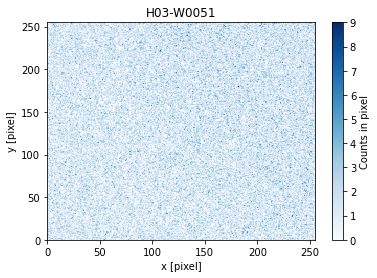

In [30]:
#hit map
hit_map(detector,hit_map_fig,RowNo,ClmNo)

### Energy and time calculation
Energy and time calculation from raw data.

In [31]:
E=energy(a, b, c, t, ToT, pocet_udalosti, RowNo, ClmNo)
T=Time(ToA, FToA, pocet_udalosti, RowNo, ClmNo)

index, matrix_index, ToA, ToT, FToA, overflow, RowNo, ClmNo, E, T = remove_interactions_with_zero_energy(index, matrix_index, ToA, ToT, FToA, overflow, RowNo, ClmNo, E, T)
E,T=Timewalk(E,T)

#sort by time
T, index, matrix_index, ToA, ToT, FToA, overflow, RowNo, ClmNo, E = (list(t) for t in zip(*sorted(zip(T, index, matrix_index, ToA, ToT, FToA, overflow, RowNo, ClmNo, E), reverse=True))) #serazeni od nejvetsiho po nejmensi

T_pom=T.copy()

#save to file
T_first, E_tot, Ntot = file_t3pa_cls_new(t3pa_cls,T)

<ipython-input-11-fe302d8691f1>:25: RuntimeWarning: invalid value encountered in double_scalars
  e1=((float(t[RowNo[i]][ClmNo[i]]))/float(2)) + ((((float(b[RowNo[i]][ClmNo[i]])+float(a[RowNo[i]][ClmNo[i]])*float(t[RowNo[i]][ClmNo[i]])-float(ToT[i]))*(float(t[RowNo[i]][ClmNo[i]]))) - 2*(float(c[RowNo[i]][ClmNo[i]])))/(float(2)*np.sqrt(float(Sqrt))))
<ipython-input-11-fe302d8691f1>:26: RuntimeWarning: invalid value encountered in double_scalars
  e2=((float(t[RowNo[i]][ClmNo[i]]))/float(2)) - ((((float(b[RowNo[i]][ClmNo[i]])+float(a[RowNo[i]][ClmNo[i]])*float(t[RowNo[i]][ClmNo[i]])-float(ToT[i]))*(float(t[RowNo[i]][ClmNo[i]]))) - 2*(float(c[RowNo[i]][ClmNo[i]])))/(float(2)*np.sqrt(float(Sqrt))))


### Detected energies during the discharge

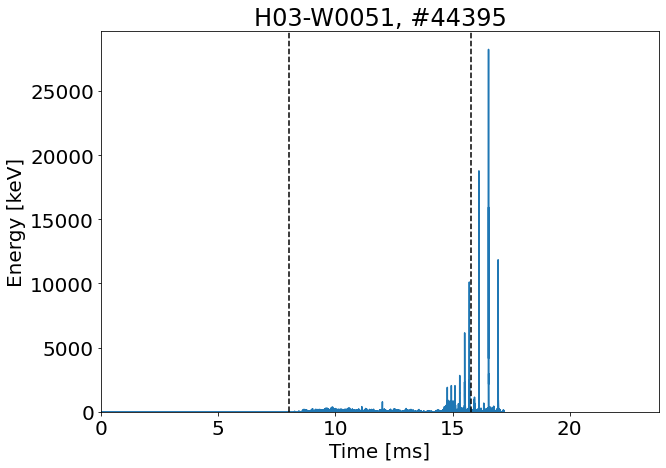

In [32]:
dt, caption, T_int_first, E = energy_spectrum_in_time(T_first, E_tot)
hist_file(E_in_time_hist, T_int_first, E, caption);

### Energy spectrum

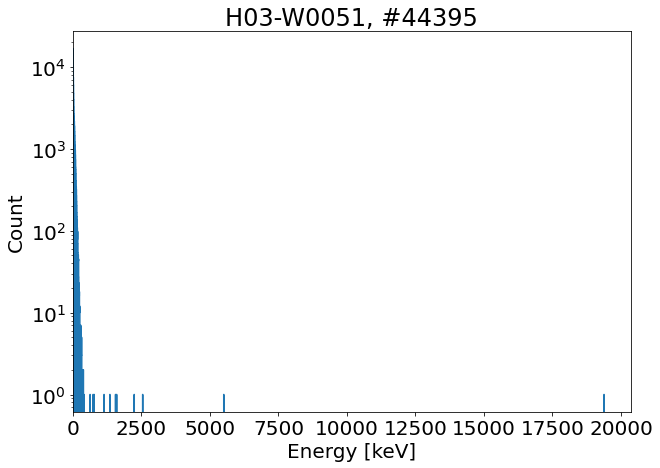

In [33]:
caption, xmean,count, xle, Etot = energy_spectrum(E_tot)
hist_file(E_hist, xmean, count, caption);

### Count of hits during the discharge

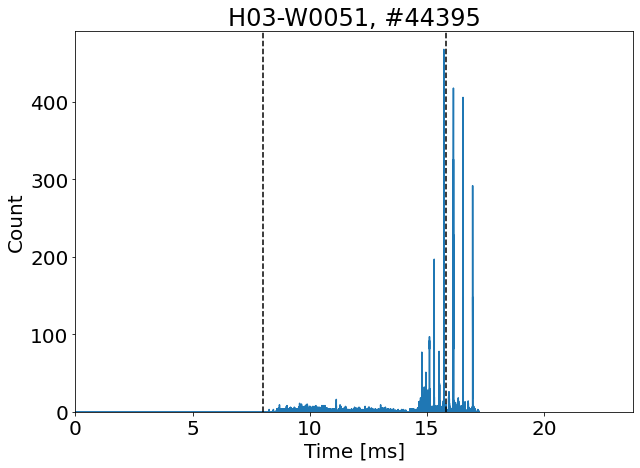

In [34]:
caption, T_hit,count1 = hits_in_time_hist_new(T_pom, dt, t_plasma_start, t_plasma_end, is_plasma, figure_count_in_time_hist)
hist_file(count_in_time_hist, T_hit, count1, caption);

#### Graph for home page 
Detected energies during the discharge + Energy spectrum

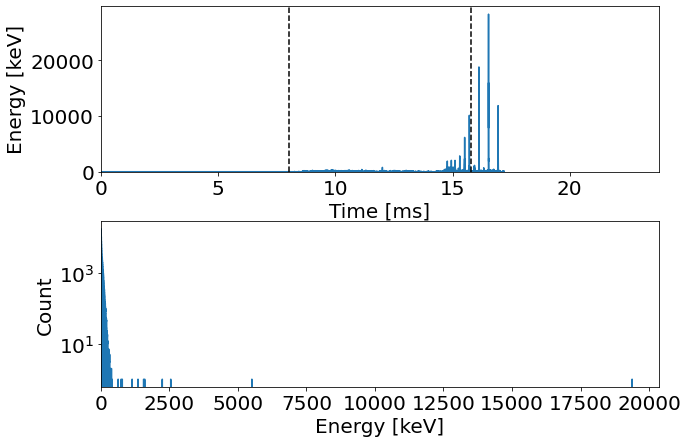

In [35]:
multiplot(icon_fig, T_int_first,E,xmean,count)

### Average size of interactions

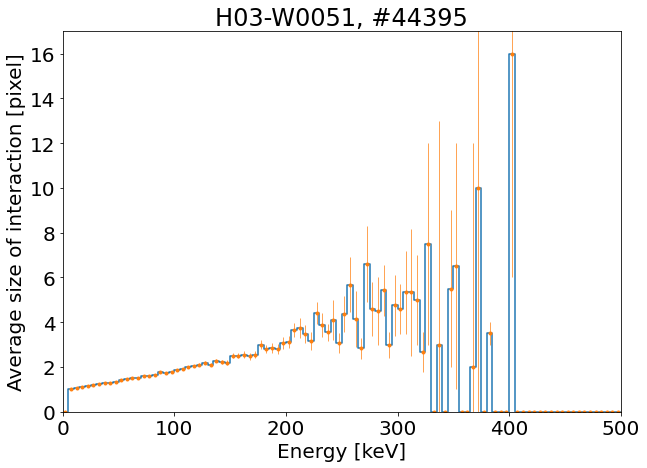

In [36]:
size_of_interactions_average(Etot, Ntot,size_interaction)

### Energy spectra for parts of doublebreadown discharges

In [37]:
#energy_spectra_doublebreakdown(Etot, T_first, file_energy_spectra_doublebreakdown)